In [1]:
import os
import torch
import utils.dnnlib as dnnlib
from utils.torch_utils import distributed as dist
import utils.setup as setup
import glob
import soundfile as sf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from IPython.display import Audio
import hydra
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Define paths
dirname = os.getcwd()
model_dir = os.path.join(dirname, "experiments/cqt")
audio_dir = os.path.join(model_dir, "test05_08_2024_0/inpainting")
inpainted_audio_dir=f"{audio_dir}/inpainted"
original_audio_dir=f"{audio_dir}/original"
masked_audio_dir=f"{audio_dir}/masked"

In [3]:
model = 'maestro' #@param ["maestro", "musicnet"]

In [4]:
def read_file(f):
    segnp, fs =sf.read(f)
    print(segnp.shape)
    if model=="maestro":  
      assert fs==22050
    elif model=="musicnet":
      assert fs==44100
    return segnp, fs
    
def process_file(f, args):
    segnp=f[:args.exp.audio_len]
    return segnp

def plot_spect(tester, audio, title, ax=None):
    seg=torch.Tensor(audio).unsqueeze(0)
    X= tester.get_spectrogram_image(seg)
    X=np.clip(X+60,0,60)/60
    X=(1-X)*255
    X=np.flipud(X).astype(np.uint8)
    X=cv2.applyColorMap(X, cv2.COLORMAP_JET)
    X = cv2.cvtColor(X, cv2.COLOR_BGR2RGB)
    #save X as a png image
    name="spectrogram.png"
    cv2.imwrite(name, X)
    input=seg.cpu().numpy()

    if ax is None:
        fig, ax = plt.subplots(figsize=(3, 3), dpi=200)
    plt.rcParams['figure.dpi'] = 200
    plt.rcParams["figure.figsize"] = (15,15)
    ax.imshow(plt.imread(name))
    ax.axis('off')
    ax.set_title(title)
    
    if ax is None:
        plt.show()
    # plt.imshow(plt.imread(name))
    # _=plt.axis('off')
    # _=plt.title(title)
    # plt.show()
    return

## Initialed trained model

In [5]:
with hydra.initialize(config_path="conf"):
    if model=="maestro":
        ckpt=f"{model_dir}/maestro_22k_8s-750000.pt"
        args = hydra.compose(config_name="conf.yaml", overrides=["exp=maestro22k_8s","network=paper_1912_unet_cqt_oct_attention_adaLN_2",
                                                                 "tester.checkpoint={ckpt}".format(ckpt=ckpt)], return_hydra_config=True)
    elif model=="musicnet":
        ckpt=f"{model_dir}/musicnet_44k_4s-560000.pt"
        args = hydra.compose(config_name="conf.yaml", overrides=["exp=musicnet44k_4s","network=paper_1912_unet_cqt_oct_attention_44k_2",
                                                                 "tester.checkpoint={ckpt}".format(ckpt=ckpt)], return_hydra_config=True)

In [6]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
diff_params=setup.setup_diff_parameters(args)
network=setup.setup_network(args, device)
tester=setup.setup_tester(args, network=network, diff_params=diff_params, test_set=None, device=device) #this will be used for making demos during training
state_dict = torch.load(ckpt, map_location="cpu")

using a kaiser window with beta= 1
Attention layer at (down) octave 4
Attention layer at (down) octave 5
Attention layer at (down) octave 6
Attention layer at (up) oct layer 6
Attention layer at (up) oct layer 5
Attention layer at (up) oct layer 4
test_set None


## Load example file from test set

In [7]:
example = 0
files=[glob.glob(os.path.join(audio_subdirs,"*.wav")) for audio_subdirs in [inpainted_audio_dir, original_audio_dir, masked_audio_dir]]
audio_files=[files[i][example] for i in range(3)]
audio_dict = dict({'Original': 1, 'Masked': 2, 'Inpainted': 0})
audio_files

['/home/shanybiton/repos/reliable-ML/audio-inpainting-diffusion/experiments/cqt/test05_08_2024_0/inpainting/inpainted/MIDI-Unprocessed_Recital16_MID--AUDIO_16_R1_2018_wav--3.wav',
 '/home/shanybiton/repos/reliable-ML/audio-inpainting-diffusion/experiments/cqt/test05_08_2024_0/inpainting/original/MIDI-Unprocessed_Recital16_MID--AUDIO_16_R1_2018_wav--3.wav',
 '/home/shanybiton/repos/reliable-ML/audio-inpainting-diffusion/experiments/cqt/test05_08_2024_0/inpainting/masked/MIDI-Unprocessed_Recital16_MID--AUDIO_16_R1_2018_wav--3.wav']

## Original audio

In [8]:
audio_list = audio_dict['Original']
audio_file = audio_files[audio_list]
segnp, fs = read_file(audio_file)
segnp = process_file(segnp, args)
Audio(data=segnp, rate=fs)

(184184,)


## Masked audio

In [9]:
audio_list = audio_dict['Masked']
audio_file = audio_files[audio_list]
segnp, fs = read_file(audio_file)
segnp = process_file(segnp, args)
Audio(data=segnp, rate=fs)

(184184,)


## Inpainted audio

In [10]:
audio_list = audio_dict['Inpainted']
audio_file = audio_files[audio_list]
segnp, fs = read_file(audio_file)
segnp = process_file(segnp, args)
Audio(data=segnp, rate=fs)

(184184,)


## Audio spectograms

(184184,)
(184184,)
(184184,)


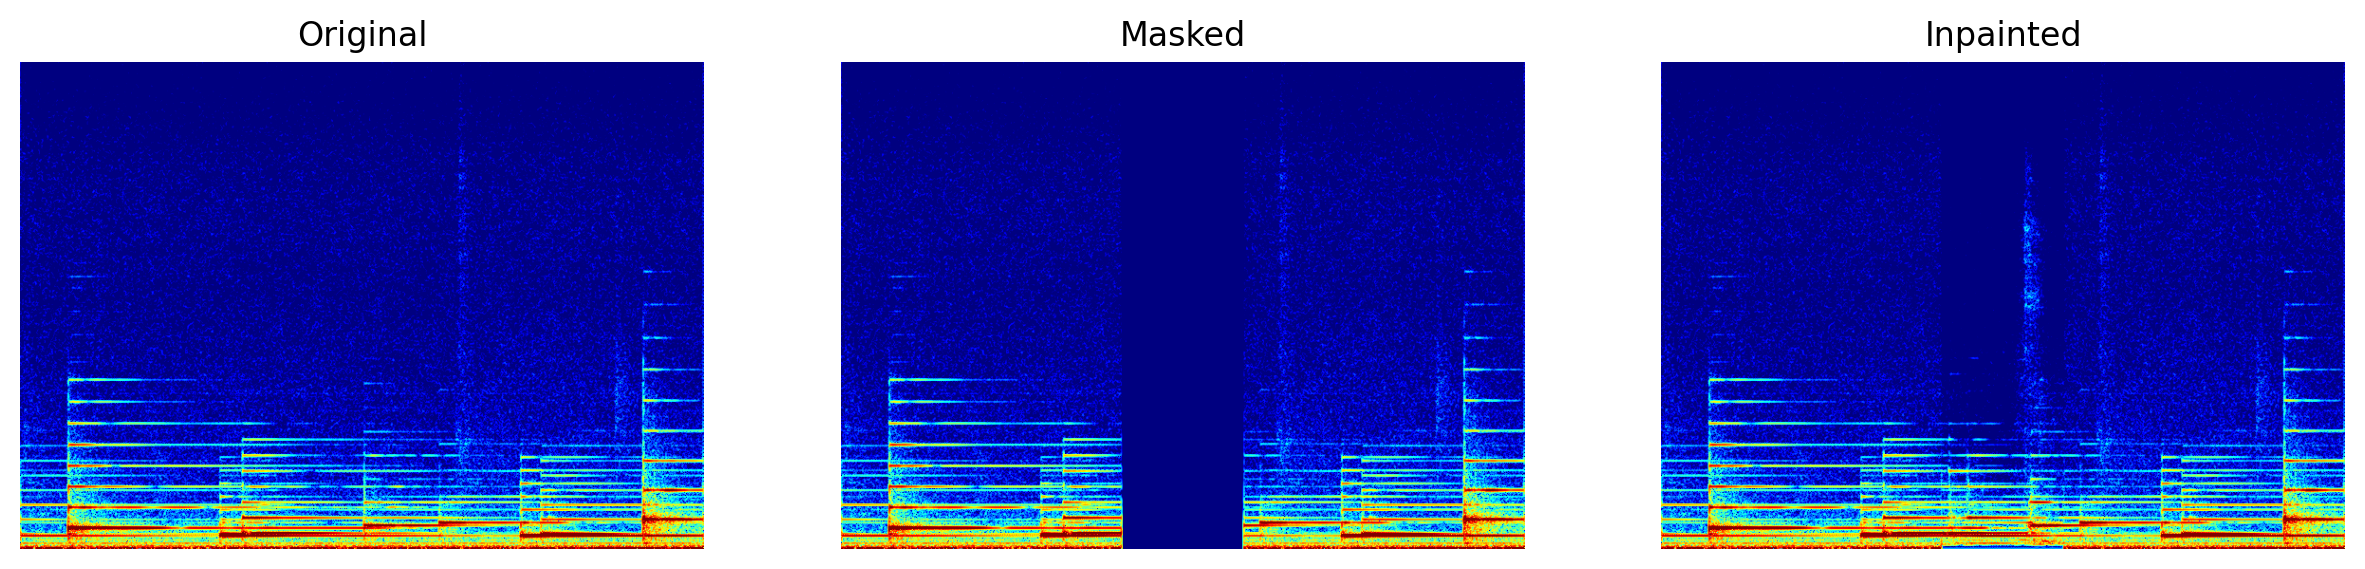

In [12]:
fig, axes = plt.subplots(1, 3)
audio_dict_for_plot = dict({'Inpainted': 2, 'Original': 0, 'Masked': 1})

for file, (title, ax_i) in zip(audio_files, audio_dict_for_plot.items()) :
    segnp, fs = read_file(file)
    segnp = process_file(segnp, args)
    plot_spect(tester, segnp, title, ax=axes[ax_i])